In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pygad
from matplotlib import cm
import matplotlib.patches as mpatches

In [2]:
def order_merge(p1, p2, job_threshold):
    o1 = []
    o2 = []
    i = 0
    j = 0
    while i < p1.shape[0] and j < p2.shape[0]:
        if p1[i] < job_threshold:
            o1.append(p1[i])
        else:
            o2.append(p1[i])
        if p2[j] >= job_threshold:
            o1.append(p2[j])
        else:
            o2.append(p2[j])
        i += 1
        j += 1
    return np.array(o1), np.array(o2)

In [3]:
def crossover_func(parents, offspring_size, ga_instance):
    offspring = []
    for i in range(0, len(parents), 2):
        p1, p2 = parents[i], parents[i+1]
        offspring.extend(order_merge(p1, p2, 5))
    return np.array(offspring)

In [4]:
def mutation_func(offspring, ga_instance):
    mutation_prob=0.3
    for i in range(len(offspring)):
        if np.random.choice([True, False], p=[1-mutation_prob, mutation_prob]):
            continue
        while True:
            a, b = np.random.randint(low=0, high=offspring.shape[1], size=2)
            if offspring[i][a] != offspring[i][b]:
                offspring[i][a], offspring[i][b] = offspring[i][b], offspring[i][a]
                break
    return offspring

In [5]:
class JobShopScheduler:
    def __init__(self, job_info, machine_info):
        self.job_info = job_info
        self.machine_info = machine_info
        self.num_jobs = len(job_info)
        self.num_operations = len(job_info[0])
        self.num_machines = len(machine_info[0])

    def calculate_makespan(self, chromosome):
        schedule = self.decode_chromosome(chromosome)
        machine_times = [0] * self.num_machines
        operation_finish_times = [[0 for _ in range(self.num_operations)] for __ in range(self.num_jobs)]
        for job, operation, machine in schedule:
            start_time = max(machine_times[machine], operation_finish_times[job][operation-1] if operation > 0 else 0)
            end_time = start_time + self.job_info[job][operation]
            operation_finish_times[job][operation] = end_time
            machine_times[machine] = end_time
        return max(machine_times)
    
    def decode_chromosome(self, chromosome):
        schedule = []
        operation_counters = [0]*self.num_jobs
        for gene in chromosome:
            job = gene
            operation = operation_counters[job]
            operation_counters[job] += 1
            machine = self.machine_info[job][operation]
            schedule.append((job, operation, machine))
        return schedule
    
    def plot_schedule(self, chromosome):
        schedule = self.decode_chromosome(chromosome)
        machine_times = [0] * self.num_machines
        operation_finish_times = [[0 for _ in range(self.num_operations)] for __ in range(self.num_jobs)]
        machine_recs = {i: [] for i in range(self.num_machines)}
        machine_jobs = {i: [] for i in range(self.num_machines)}
        for job, operation, machine in schedule:
            start_time = max(machine_times[machine], operation_finish_times[job][operation-1] if operation > 0 else 0)
            end_time = start_time + self.job_info[job][operation]
            operation_finish_times[job][operation] = end_time
            machine_times[machine] = end_time
            machine_recs[machine].append((start_time, self.job_info[job][operation]))
            machine_jobs[machine].append(job)
        y = 0
        cmap = cm.get_cmap('Spectral')
        plt.figure(figsize=(15, 7))
        for i in range(self.num_machines):
            recs = machine_recs[i]
            jobs = machine_jobs[i]
            colors = list(map(lambda x: cmap(x/self.num_jobs), jobs))
            plt.broken_barh(recs, (y, 10), facecolors=colors)
            y += 15
        plt.gca().set_ylim(0, y)
        plt.gca().set_yticks(list(range(5, y+1, 15)), labels=list(map(lambda x: "M{}".format(x), range(self.num_machines))))
        create_job_patch = lambda x: mpatches.Patch(color=cmap(x/self.num_jobs), label="J{}".format(x))
        patches = list(map(create_job_patch, range(self.num_jobs)))
        plt.legend(handles=patches, loc='best')
        plt.show()

In [6]:
# Example input with 2 jobs, 2 operations per job, and 2 machines
job_info = [
    [29, 78, 9, 36, 49, 11, 62, 56, 44, 21],
    [43, 90, 75, 11, 69, 28, 46, 46, 72, 30],
    [91, 85, 39, 74, 90, 10, 12, 89, 45, 33],
    [81, 95, 71, 99, 9, 52, 85, 98, 22, 43],
    [14, 6, 22, 61, 26, 69, 21, 49, 72, 53],
    [84, 2, 52, 95, 48, 72, 47, 65, 6, 25],
    [46, 37, 61, 13, 32, 21, 32, 89, 30 ,55],
    [31, 86, 46, 74, 32, 88, 19, 48, 36, 79],
    [76, 69, 76, 51, 85, 11, 40, 89, 26, 74],
    [85, 13, 61, 7, 64, 76, 47, 52, 90, 45]
]

machine_info = [
    [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
    [0, 2, 4, 9, 3, 1, 6, 5, 7, 8],
    [1, 0, 3, 2, 8, 5, 7, 6, 9, 4],
    [1, 2, 0, 4, 6, 8, 7, 3, 9, 5],
    [2, 0, 1, 5, 3, 4, 8, 7, 9, 6],
    [2, 1, 5, 3, 8, 9, 0, 6, 4, 7],
    [1, 0, 3, 2, 6, 5, 9, 8, 7, 4],
    [2, 0, 1, 5, 4, 6, 8, 9, 7, 3],
    [0, 1, 3, 5, 2, 9, 6, 7, 4, 8],
    [1, 0, 2, 6, 8, 9, 5, 3, 4, 7]
]

scheduler = JobShopScheduler(job_info, machine_info)

In [7]:
def fitness_func(ga_instance, solution, solution_idx):
    return 1/scheduler.calculate_makespan(solution)

In [8]:
n_jobs = 10
n_ops = 10
bblocks = list(range(n_jobs))*n_ops
np.unique(bblocks, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([10, 10, 10, 10, 10, 10, 10, 10, 10, 10], dtype=int64))

In [9]:
create_random_individual = lambda : np.random.choice(bblocks, size=len(bblocks), replace=False)

In [10]:
# initial = [create_random_individual() for _ in range(200)]

In [11]:
# np.savetxt("initial.txt", initial)

In [12]:
# For consistent results, we load a previously random generated population from a txt file
initial = np.loadtxt("initial.txt")

In [13]:
ga_instance = pygad.GA(num_generations=500,
                       num_parents_mating=100,
                       sol_per_pop=200,
                       keep_elitism=0,
                       initial_population=initial,
                       fitness_func=fitness_func,
                       crossover_type=crossover_func,
                       mutation_type=mutation_func,
                       gene_type=int,
                       parent_selection_type='rank',
                       random_seed=0
                      )

In [14]:
ga_instance.run()

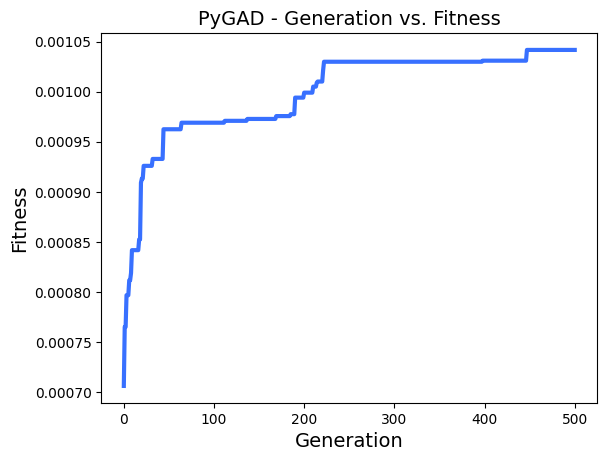

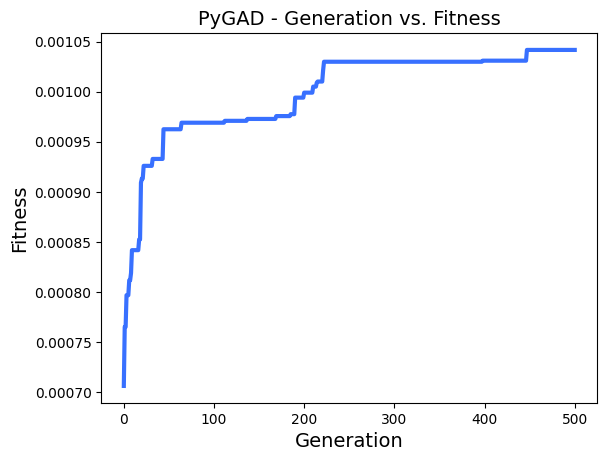

In [15]:
ga_instance.plot_fitness()

In [16]:
solution, solution_fitness, solution_idx = ga_instance.best_solution()

In [17]:
scheduler.calculate_makespan(solution)

960

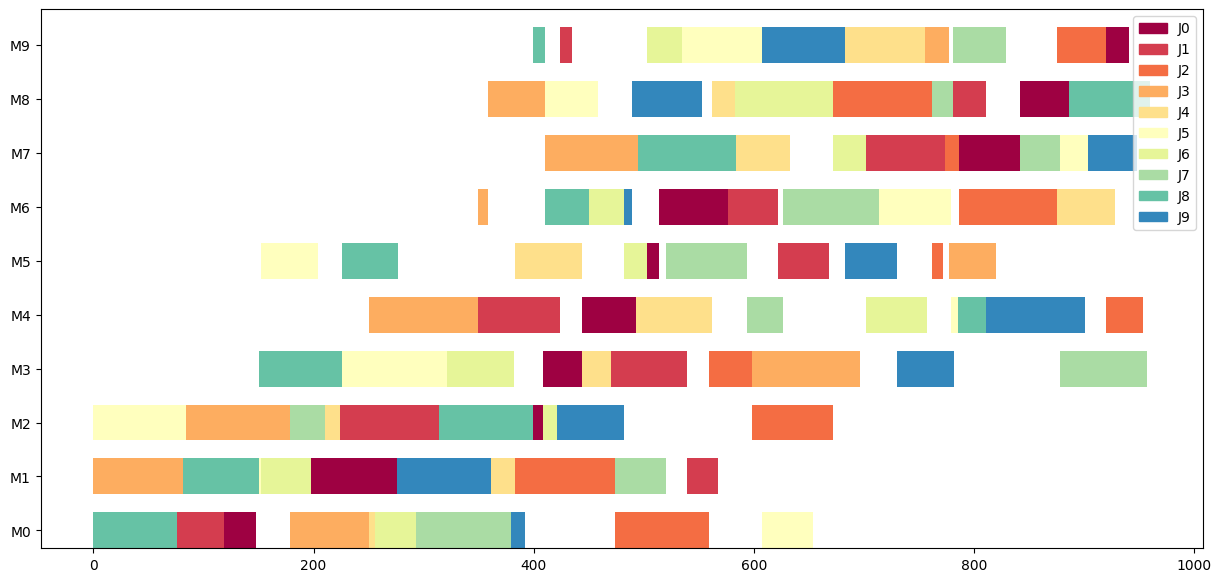

In [18]:
scheduler.plot_schedule(solution)